Sample use of the algorithm with Jupyter.

# Notebook initialization
## Download module

In [159]:
import os
import urllib.request
import importlib
import matplotlib.pyplot as plt
plt.close('all')

# if not os.path.isfile('mtf_estimator_algorithm.py'):
#     urllib.request.urlretrieve('https://raw.githubusercontent.com/JorgeGIlG/MTF_Estimator/devel/qgis_plugin/mtf_estimator/mtf_estimator_algorithm.py',
#                                'mtf_estimator_algorithm.py')


## Download sample image

In [160]:
# if not os.path.isfile('baotou_CALVAL_L0R_000000_20200328T032332_202003T032334_MTF_12196_7333.tif'):
#     urllib.request.urlretrieve('https://github.com/JorgeGIlG/MTF_Estimator/raw/devel/data/baotou_CALVAL_L0R_000000_20200328T032332_202003T032334_MTF_12196_7333.tif',
#                                'baotou_CALVAL_L0R_000000_20200328T032332_202003T032334_MTF_12196_7333.tif')


In [161]:
import mtf_estimator_algorithm
import osgeo
import numpy as np
from osgeo import ogr, osr, gdal
importlib.reload(mtf_estimator_algorithm)

%matplotlib widget


# Declare inputs

In [162]:


# Raster to mask and crop using Aoi_Wkt
Image_File = 'image-for-psf-0-loc1.png'
# Band number. First is 1
Band_n = 1


In [163]:
!ls *.png


icon.png  image-for-psf-0-loc1.png


# Read, mask and crop input file

In [164]:
def process(Aoi_Wkt):
    gdal_layer = gdal.Open(Image_File, gdal.GA_ReadOnly)
    gt = list(gdal_layer.GetGeoTransform())
    xsize = gdal_layer.RasterXSize
    ysize = gdal_layer.RasterYSize
    band = gdal_layer.GetRasterBand(Band_n)
    raster_srs = osr.SpatialReference()
    raster_srs.ImportFromWkt(gdal_layer.GetProjection())
    vector_srs = raster_srs


    # https://gdal.org/tutorials/osr_api_tut.html#crs-and-axis-order
    if int(osgeo.__version__[0]) >= 3:
        # GDAL 3 changes axis order: https://github.com/OSGeo/gdal/issues/1546
        raster_srs.SetAxisMappingStrategy(osgeo.osr.OAMS_TRADITIONAL_GIS_ORDER)
        vector_srs.SetAxisMappingStrategy(osgeo.osr.OAMS_TRADITIONAL_GIS_ORDER)

    if str(raster_srs) == '':
        coord_transform = None
        # self.console('WARNING: Raster with no CRS')
        gt[5] = -1*gt[5]
    else:
        coord_transform = osr.CoordinateTransformation(vector_srs, raster_srs)


    memlayer_drv = ogr.GetDriverByName('Memory')
    memlayer_ds = memlayer_drv.CreateDataSource('')
    memlayer = memlayer_ds.CreateLayer('aoi', raster_srs, geom_type=ogr.wkbPolygon)
    memlayer.CreateField(ogr.FieldDefn('id', ogr.OFTInteger))
    featureDefn = memlayer.GetLayerDefn()
    memfeat = ogr.Feature(featureDefn)
    geom = ogr.CreateGeometryFromWkt(Aoi_Wkt)
    if not coord_transform is None:
        geom.Transform(coord_transform)

    memfeat.SetGeometry(geom)
    memlayer.CreateFeature(memfeat)

    # Get extent in raster coords
    e = np.array(memlayer.GetExtent()).copy()
    e = np.reshape(e, [2, 2])
    e = np.array(np.meshgrid(e[0], e[1]))
    E = e.T.reshape(-1, 2)
    m = np.reshape(np.array(gt).copy(), [2, 3])
    A = m[:, 0]
    m = m[:, 1:]
    M = np.linalg.inv(m)
    col_list, row_list = np.matmul(M, (E-A).T)
    pxoffset = 5
    col_min = int(np.max([np.floor(np.min(col_list)) - pxoffset, 1]))
    col_max = int(np.min([np.ceil(np.max(col_list))+pxoffset, xsize-1]))
    row_min = int(np.max([np.floor(np.min(row_list)) - pxoffset, 1]))
    row_max = int(np.min([np.ceil(np.max(row_list))+pxoffset, ysize-1]))
    sub_gt = gt
    sub_gt[0] = gt[0] + gt[1]*col_min + gt[2]*row_min
    sub_gt[3] = gt[3] + gt[4]*col_min + gt[5]*row_min
    sub_xsize = int(col_max-col_min)
    sub_ysize = int(row_max-row_min)

    memraster_drv = gdal.GetDriverByName('MEM')
    print(sub_xsize, sub_ysize)
    memraster = memraster_drv.Create('', sub_xsize, sub_ysize, 1, band.DataType)

    memraster.SetProjection(gdal_layer.GetProjection())
    memraster.SetGeoTransform(sub_gt)
    memband = memraster.GetRasterBand(1)
    memband.WriteArray(np.zeros([sub_ysize, sub_xsize]))
    gdal.RasterizeLayer(memraster, [1], memlayer, burn_values=[1])
    mask = memband.ReadAsArray(0, 0, sub_xsize, sub_ysize)
    memband.WriteArray(mask*band.ReadAsArray(col_min, row_min, sub_xsize, sub_ysize))
    mask = None
    return memraster


# Run algorithm

91 132
Row: 0
Not enough pixels in the transect. Set to invalid.
Row: 1
Not enough pixels in the transect. Set to invalid.
Row: 2
Not enough pixels in the transect. Set to invalid.
Row: 3
Not enough pixels in the transect. Set to invalid.
Row: 4
Not enough pixels in the transect. Set to invalid.
Row: 5
Not enough pixels in the transect. Set to invalid.
Row: 6
Not enough pixels in the transect. Set to invalid.
Row: 7
Not enough pixels to build a PSF. Set to invalid
Row: 8
Not enough pixels to build a PSF. Set to invalid
Row: 9
Not enough pixels to build a PSF. Set to invalid
Row: 10
Row: 11
Row: 12
Row: 13
Row: 14
Row: 15
Row: 16
Row: 17
Row: 18
Row: 19
Row: 20
Set to invalid due to bad 'l' covariance
Row: 21
Row: 22
Row: 23
Row: 24
Row: 25
Row: 26
Row: 27
Row: 28
Row: 29
Row: 30
Row: 31
Row: 32
Row: 33
Set to invalid due to bad 'l' covariance
Row: 34
Row: 35
Row: 36
Set to invalid due to bad 'l' covariance
Row: 37
Row: 38
Row: 39
Row: 40
Set to invalid due to bad 'l' covariance
Row: 41

/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',



############ Results
Angle: 17.081844°
Smooth: 1.167264e-01 
FWHM: 1.364000 px
MTF0: (0.9999999999999998+0j) 
MTF30: 0.444481 
MTF50: 0.340365 
MTF@Nyquist: 0.208086 
####################



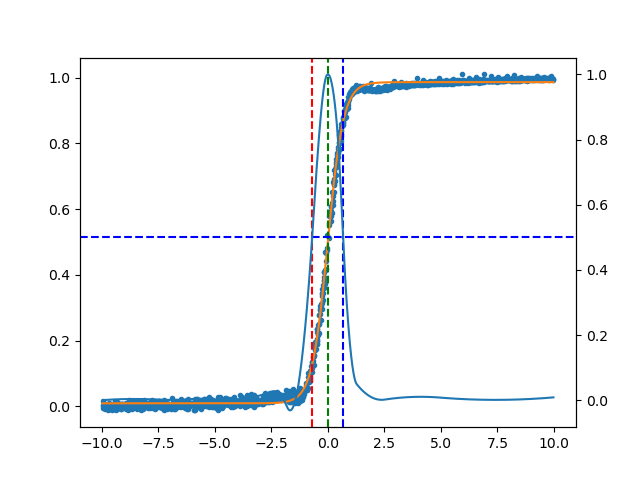

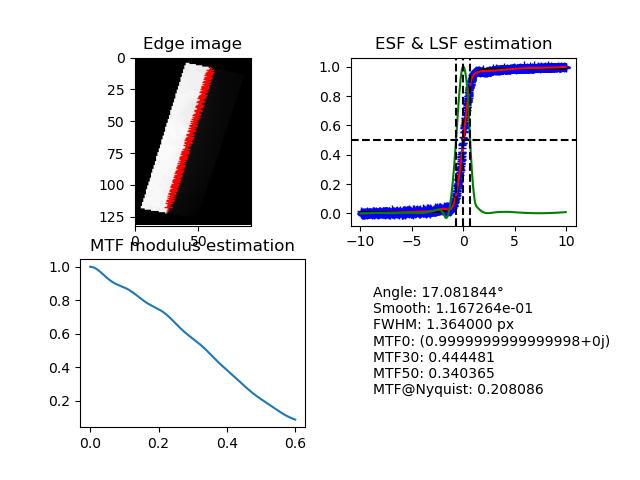

In [165]:
importlib.reload(mtf_estimator_algorithm)
# Area of Interest polygon in WKT
Aoi_Wkt = '''
Polygon ((
584 -175,
630 -184,
593 -297,
549 -289,
584 -175
))
'''

# Aoi_Wkt = '''
# Polygon ((
# 100 -10,
# 632 -10,
# 632 -445,
# 100 -445,
# 100 -10
# ))
# '''
mtf_estimator_algorithm.Mtf(process(Aoi_Wkt))


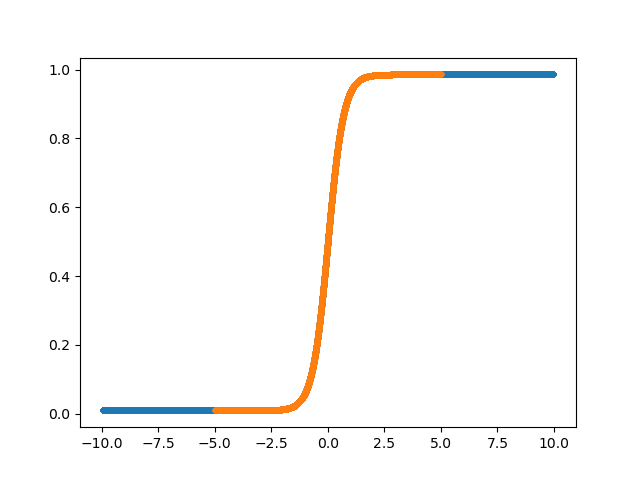

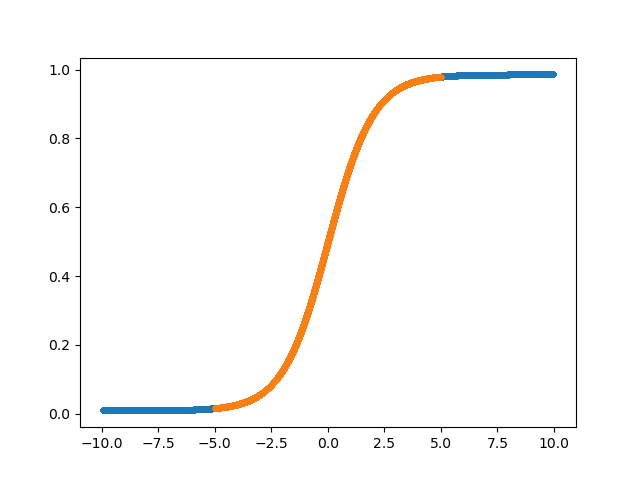

In [166]:
# def sigmoid(x, a, b, l, s):
#     return a+b*(1/(1+np.power(np.e, -l*(x+s))))

def test(L=None):
    import matplotlib.pyplot as plt
    x = [-9.95768915383951, 9.97456435677212]
    OverSampFreq = np.float64(1e3)   
    a, b, l, s, optSmooth = 0.009548118522661594, 0.9765408418125651, 2.883940582009699, 0.004689178501557088, 0.13395440581238172
    if L is not None:
        l = L
    xAux = np.arange(np.min(x), np.max(x), step=1/OverSampFreq)    
    S = mtf_estimator_algorithm.sigmoid(xAux, a, b, l, s)
    fig, ax = plt.subplots(1,1)
    ax.plot(xAux, S, '.')
   
    def get_position(data, value):
        return np.argmin(np.abs(data-value))



    center_pos = get_position(S, s)    
    max_pos = get_position(S[center_pos:], np.quantile(S[center_pos:], 0.75))
    distance_pos = max_pos - center_pos
    ax.plot(xAux[center_pos - distance_pos:center_pos + distance_pos], S[center_pos - distance_pos:center_pos + distance_pos], '.')
    
test()
test(L=1)

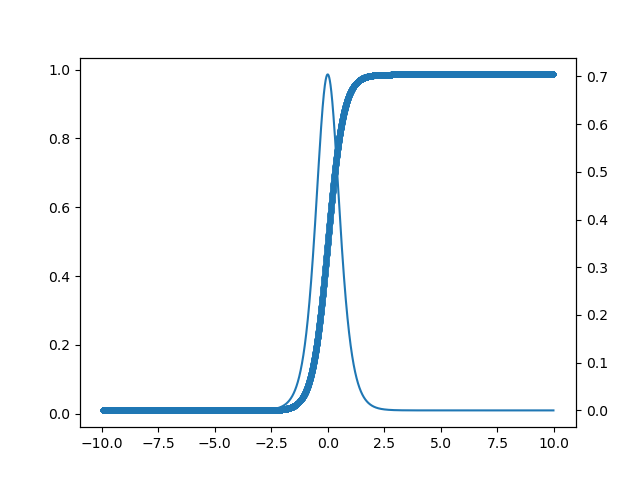

In [167]:
# def sigmoid(x, a, b, l, s):
#     return a+b*(1/(1+np.power(np.e, -l*(x+s))))

def test(L=None):
    import numpy as np
    import matplotlib.pyplot as plt

    def derivative(x):
        return (b * l) / (np.exp(l * (s + x)) * (1 + np.exp(-l * (s + x)))**2)

    x = [-9.95768915383951, 9.97456435677212]
    OverSampFreq = np.float64(1e3)   
    a, b, l, s, optSmooth = 0.009548118522661594, 0.9765408418125651, 2.883940582009699, 0.004689178501557088, 0.13395440581238172
    if L is not None:
        l = L
    xAux = np.arange(np.min(x), np.max(x), step=1/OverSampFreq)    
    S = mtf_estimator_algorithm.sigmoid(xAux, a, b, l, s)
    fig, ax = plt.subplots(1,1)
    ax.plot(xAux, S, '.')
   
    tax = ax.twinx()
    tax.plot(xAux, derivative(xAux))



    
test()
            


